In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style = 'darkgrid')

from utils import scatter_plot
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Import Dataset

In [4]:
train = pd.read_csv('./data/SynDepth_train_set.csv', converters={'site_no': str}, low_memory=False)
test = pd.read_csv('./data/SynDepth_test_set.csv', converters={'site_no': str}, low_memory=False)

In [5]:
X_train = train.drop(columns=['site_no', 'mean_depth_va'])
X_test = test.drop(columns=['site_no', 'mean_depth_va'])

y_train = train[['mean_depth_va']]
y_test = test[['mean_depth_va']]

In [6]:
# log_train = np.log10(train.drop(columns=['site_no']).to_numpy())
# log_test = np.log10(test.drop(columns=['site_no']).to_numpy())

X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train).astype('float32')

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(np.array(y_train).reshape(-1, 1)).astype('float32').ravel()

X_test = X_scaler.transform(X_test).astype('float32')

In [5]:
## Model
svr = SVR()
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9],
              'kernel': ['rbf']}

svr_grid = GridSearchCV(svr, param_grid, cv=8, n_jobs=30, verbose=3)
svr_grid.fit(X_train, y_train)

Fitting 8 folds for each of 32 candidates, totalling 256 fits


GridSearchCV(cv=8, estimator=SVR(), n_jobs=30,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 0.6,
                                   0.9],
                         'kernel': ['rbf']},
             verbose=3)

In [6]:
print(svr_grid.best_params_)
print(svr_grid.best_score_)

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.8835356733329212


In [8]:
import pickle

with open('./data/ml_weights/svr_best_model', "wb") as fp:
    pickle.dump(svr_grid.best_estimator_, fp)

In [1]:
import pickle

with open('./data/ml_weights/svr_best_model', "rb") as fp:
    svr_grid = pickle.load(fp)

NSE: 0.9733, R2: 0.9734, PBias: 0.5459, MSE: 1.0073


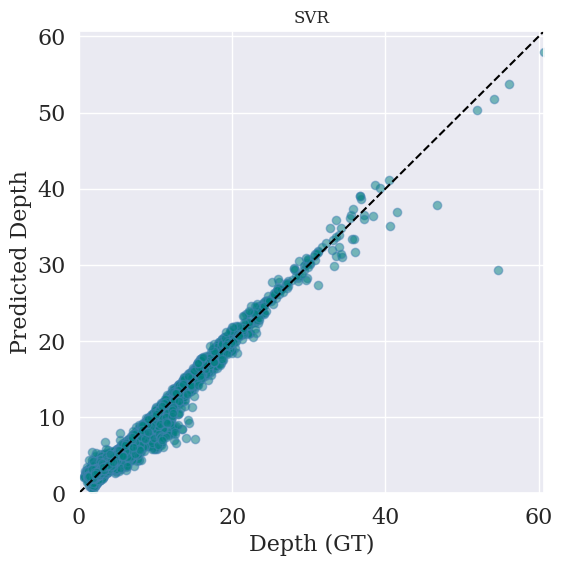

In [7]:
y_pred = svr_grid.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()
scatter_plot(y_test, y_pred, model_name='SVR')